In [1]:
import os
import numpy as np
from keras.models import Sequential
from keras.optimizers import SGD
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D 
from keras.layers import AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from sklearn.metrics import log_loss
from skimage import io
from skimage.transform import resize
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### read and prepare data
Images in the dataset come in different sizes. To use them in a fine-tuned VGG16 with imagenet pretrained weights, they are rescaled into 224x224 and RBG average is subtracted from each image.

In [2]:
VGG_MEAN = np.reshape([123.68, 116.78, 103.94], (1, 1, 3))   # Average RGB of Imagenet
img_rows, img_cols = 224, 224
channel = 3
batch_size = 32
epochs = 50

In [3]:
num_classes = 0
X = []
Y = []
for cat in os.listdir('simpsons_dataset'):
    cat_path = os.path.join('simpsons_dataset', cat)
    img_files = os.listdir(cat_path)
    count = 0
    if len(img_files) > 1400:
        for img in img_files:
            tmp = io.imread(os.path.join(cat_path, img))
            X.append(resize(tmp, (224, 224)) - VGG_MEAN)
            Y.append(num_classes)
            count += 1
            if count == 1000:
                break            
        num_classes += 1
        if num_classes == 2:
            break

/home/tsolak/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
print(num_classes)

2


In [6]:
# Y = to_categorical(Y, num_classes=num_classes)
Y = np.zeros(2000)
Y[1000:] += 1

### display sample images

To limit the model's size and training time, the classification is done only between two characters, Homer and Ned.

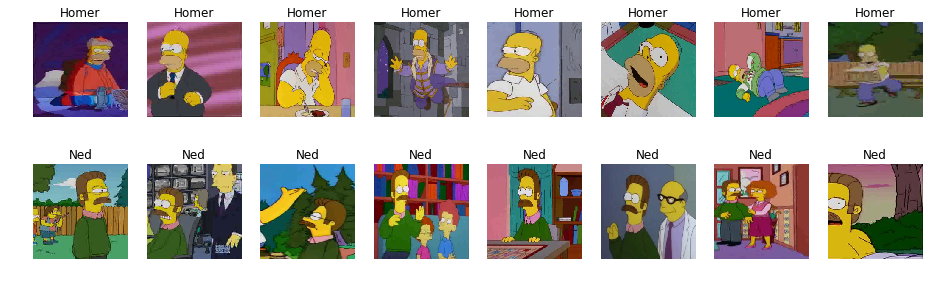

In [5]:
fig = plt.figure(figsize=(20, 10))
names = ['Homer', 'Ned']
for i in range(2):
    for j in range(1, 9):
        a = fig.add_subplot(4, 10, i * 10 + j)
        image = X[i * 1000 - j]
        imshow(image + VGG_MEAN)
        plt.title(names[i])
        axis('off')

### split data for training and evaluation
Data is split into 80% train, 10% development and 10% test sets.

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(X), np.array(Y), test_size=.2)

In [10]:
X_dev, X_test, Y_dev, Y_test = train_test_split(X_test, Y_test, test_size=.5)

### load pretrained model
The model we are going to train will be built on VGG16 with weights pretrained on ImageNet. We will use only the convolutional layers, and ignore the fully connected top layers.

In [14]:
cropped_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
cropped_model.layers

In [16]:
# for layer in cropped_model.layers:
#     layer.trainable = False

We add two dense layers on top of the loaded model, with 0.5 dropout inbetween for regularization.

In [23]:
simpsons_vgg16 = Sequential()
simpsons_vgg16.add(cropped_model)
simpsons_vgg16.add(Flatten())
simpsons_vgg16.add(Dense(512, activation='relu'))
simpsons_vgg16.add(Dropout(.5))
# simpsons_vgg16.add(Dense(num_classes, activation='softmax'))
simpsons_vgg16.add(Dense(1, activation='sigmoid'))

A very small learning rate is set, because otherwise the model seems not to learn anything.

In [27]:
sgd = SGD(lr=1e-5, decay=1e-9, momentum=0.9, nesterov=True)
# simpsons_vgg16.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
simpsons_vgg16.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
simpsons_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 27,560,769
Trainable params: 27,560,769
Non-trainable params: 0
_________________________________________________________________


### training and evaluation

In [28]:
simpsons_vgg16.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_dev, Y_dev))

Train on 1600 samples, validate on 200 samples
Epoch 1/50
1600/1600 [==============================] - 1203s 752ms/step - loss: 0.9747 - acc: 0.5056 - val_loss: 0.6914 - val_acc: 0.5300
Epoch 2/50
1600/1600 [==============================] - 1222s 764ms/step - loss: 0.8032 - acc: 0.5025 - val_loss: 0.6932 - val_acc: 0.5200
Epoch 3/50
1600/1600 [==============================] - 1223s 764ms/step - loss: 0.7507 - acc: 0.5012 - val_loss: 0.6878 - val_acc: 0.5200
Epoch 4/50
1600/1600 [==============================] - 1222s 764ms/step - loss: 0.7231 - acc: 0.5088 - val_loss: 0.6963 - val_acc: 0.4750
Epoch 5/50
1600/1600 [==============================] - 1218s 761ms/step - loss: 0.7215 - acc: 0.5188 - val_loss: 0.6847 - val_acc: 0.5200
Epoch 6/50
1600/1600 [==============================] - 1220s 763ms/step - loss: 0.7048 - acc: 0.5156 - val_loss: 0.6975 - val_acc: 0.5200
Epoch 7/50
1600/1600 [==============================] - 1219s 762ms/step - loss: 0.6988 - acc: 0.5275 - val_loss: 0.667

In [29]:
simpsons_vgg16.evaluate(X_test, Y_test)

200/200 [==============================] - 38s 190ms/step


[0.5329959034919739, 0.73]

After 50 epochs, the network reaches **75.12%** accuracy on train data, **74.0%** on development set and **73.0%** on test.